In [194]:
import xarray as xr
import numpy as np
from geopy.distance import geodesic
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw

def read_nc_file(file):
    ds = xr.open_dataset(file)
    pressure = ds['pressure'].values.flatten()
    temperature = ds['temperature'].values.flatten()
    salinity = ds['salinity'].values.flatten()
    latitude = ds['latitude'].values.flatten()[0]
    longitude = ds['longitude'].values.flatten()[0]
    time = ds['time'].values.flatten()[0]
    ds.close()
    return pressure, temperature, salinity, latitude, longitude, time

def process_casts(files, indices):
    casts = []
    for i in indices:
        file = files[i]
        pressure, temperature, salinity, latitude, longitude, time = read_nc_file(file)
        cast = {
            'pressure': pressure,
            'temperature': temperature,
            'salinity': salinity,
            'latitude': latitude,
            'longitude': longitude,
            'time': time
        }
        casts.append(cast)
    return casts

def calculate_distances(casts):
    base_coord = (casts[0]['latitude'], casts[0]['longitude'])
    distances = [0]  # Distance from the first included cast is 0
    for cast in casts[1:]:
        coord = (cast['latitude'], cast['longitude'])
        distance = geodesic(base_coord, coord).kilometers
        distances.append(distance)
    return distances

def create_dataset(casts, distances):
    # Determine the common pressure grid
    all_pressures = np.concatenate([cast['pressure'] for cast in casts])
    unique_pressures = np.unique(all_pressures)
    
    temp_interp = np.empty((len(casts), len(unique_pressures)))
    sal_interp = np.empty((len(casts), len(unique_pressures)))
    
    for i, cast in enumerate(casts):
        temp_interp[i] = np.interp(unique_pressures, cast['pressure'], cast['temperature'])
        sal_interp[i] = np.interp(unique_pressures, cast['pressure'], cast['salinity'])
    
    latitudes = np.array([cast['latitude'] for cast in casts])
    longitudes = np.array([cast['longitude'] for cast in casts])
    times = np.array([cast['time'] for cast in casts])
    
    # Fill values below the seafloor (maximum pressure) with NaN
    for i, cast in enumerate(casts):
        max_pressure = np.max(cast['pressure'])
        temp_interp[i][unique_pressures > max_pressure] = np.nan
        sal_interp[i][unique_pressures > max_pressure] = np.nan
    
    ds = xr.Dataset(
        {
            'temperature': (['cast', 'pressure'], temp_interp),
            'salinity': (['cast', 'pressure'], sal_interp),
            'latitude': (['cast'], latitudes),
            'longitude': (['cast'], longitudes),
            'time': (['cast'], times),
            'distance': (['cast'], distances)
        },
        coords={
            'cast': np.arange(len(casts)),
            'pressure': unique_pressures,
        }
    )
    return ds



# Directory containing the .nc files
nc_files_dir = 'Y:/in2024_v04/ctd/processing/in2024_v04/cap/cappro/avg'

# List all .nc files in the directory
nc_files = [os.path.join(nc_files_dir, file) for file in os.listdir(nc_files_dir) if file.endswith('.nc')]

# Define the indices for each transect
transect1_indices = [1, 2, 3,4]
transect2_indices = [5,11, 14, 13, 12]
transect3_indices = [7,6, 8, 9, 10]
transect_4_indices =[29,28,30,31]
transect5_indices=[25,27,26]

transects_indices = [transect1_indices, transect2_indices, transect3_indices,transect_4_indices,transect5_indices]

# Process each transect
transects_casts = [process_casts(nc_files, indices) for indices in transects_indices]
transects_distances = [calculate_distances(casts) for casts in transects_casts]

# Create the combined datasets for each transect
transects_datasets = [create_dataset(casts, distances) for casts, distances in zip(transects_casts, transects_distances)]




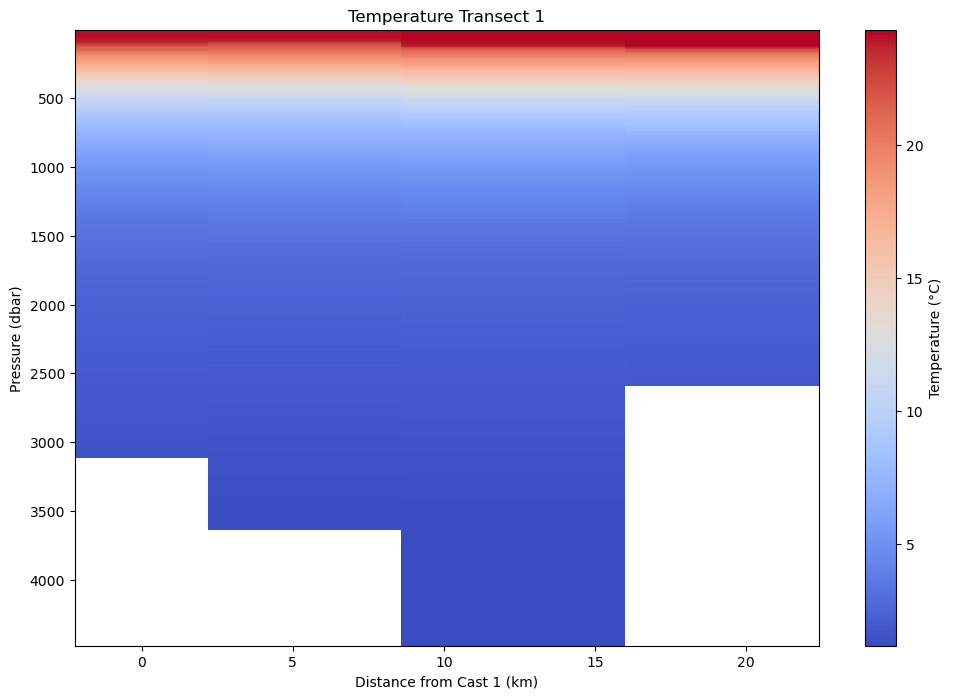

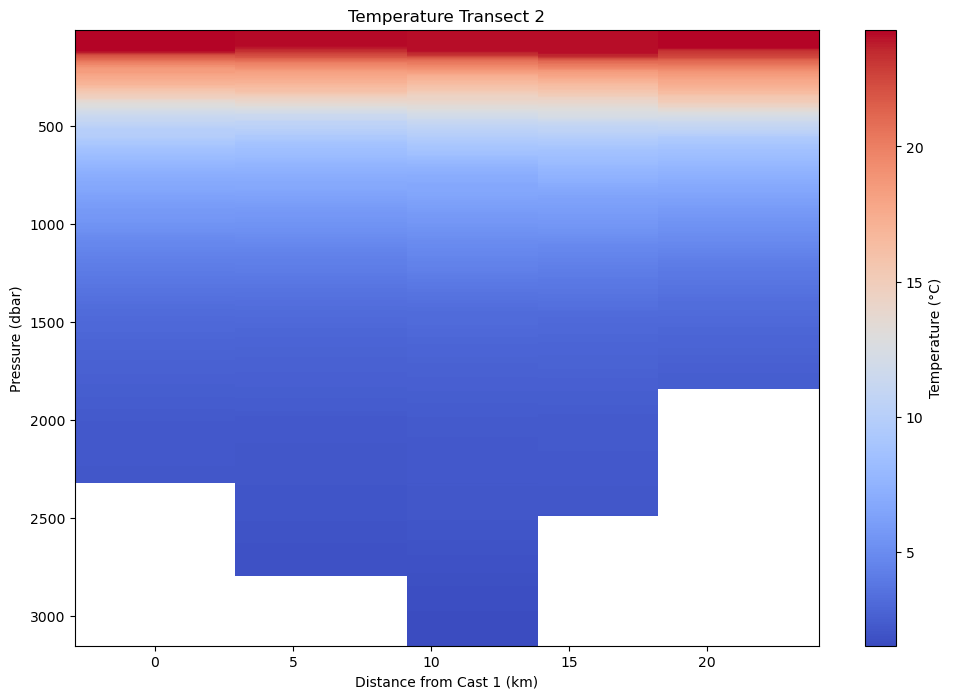

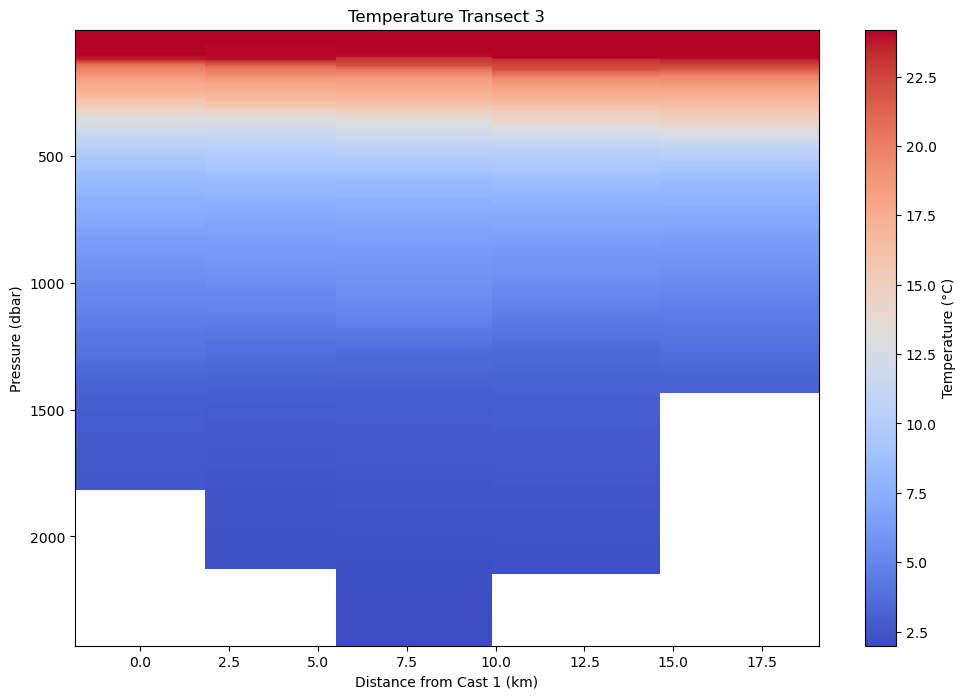

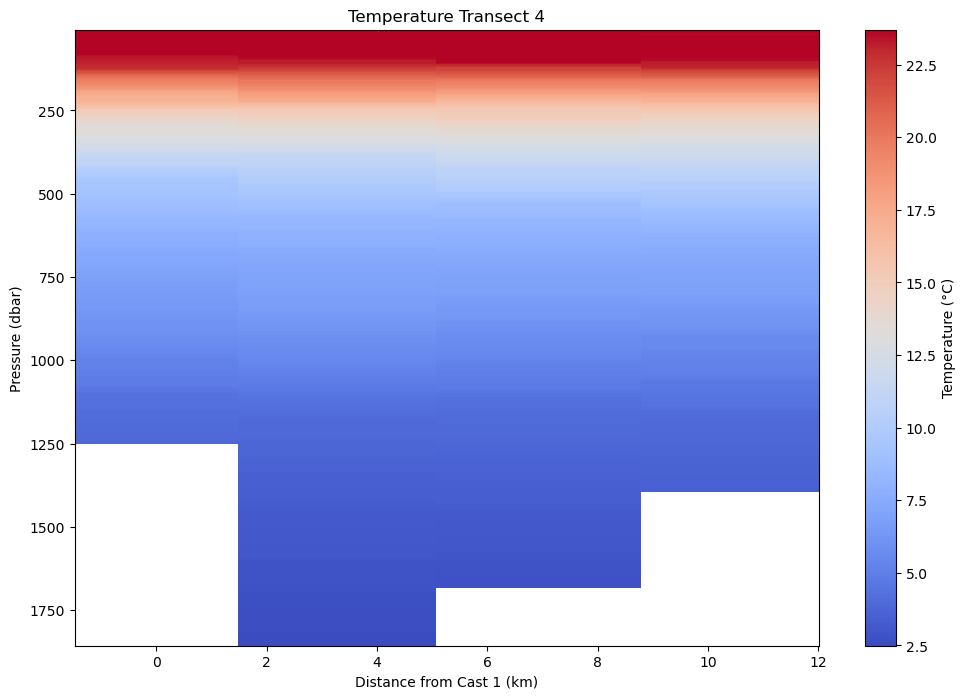

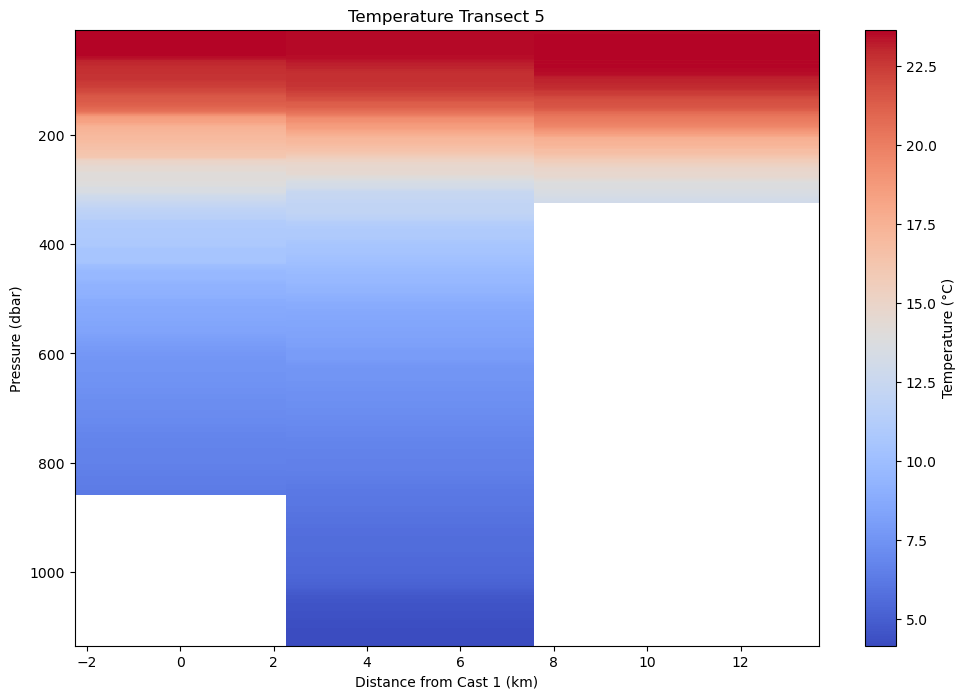

In [195]:
def plot_transect(ds, transect_number):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Extract the data for plotting
    distance = ds['distance'].values
    pressure = ds['pressure'].values
    temperature = ds['temperature'].values
    
    # Create the meshgrid for distance and pressure
    X, Y = np.meshgrid(distance, pressure)
    
    # Plot the temperature as a color mesh
    c = ax.pcolormesh(X, Y, temperature.T, shading='auto', cmap='coolwarm')
    
    # Add color bar
    cb = fig.colorbar(c, ax=ax)
    cb.set_label('Temperature (°C)')
    
    # Set axis labels and title
    ax.set_xlabel('Distance from Cast 1 (km)')
    ax.set_ylabel('Pressure (dbar)')
    ax.set_title(f'Temperature Transect {transect_number}')
    
    # Reverse the y-axis to have pressure increasing downwards
    ax.invert_yaxis()
    
    plt.show()

# Plot the transects
for i, ds in enumerate(transects_datasets):
    plot_transect(ds, i + 1)

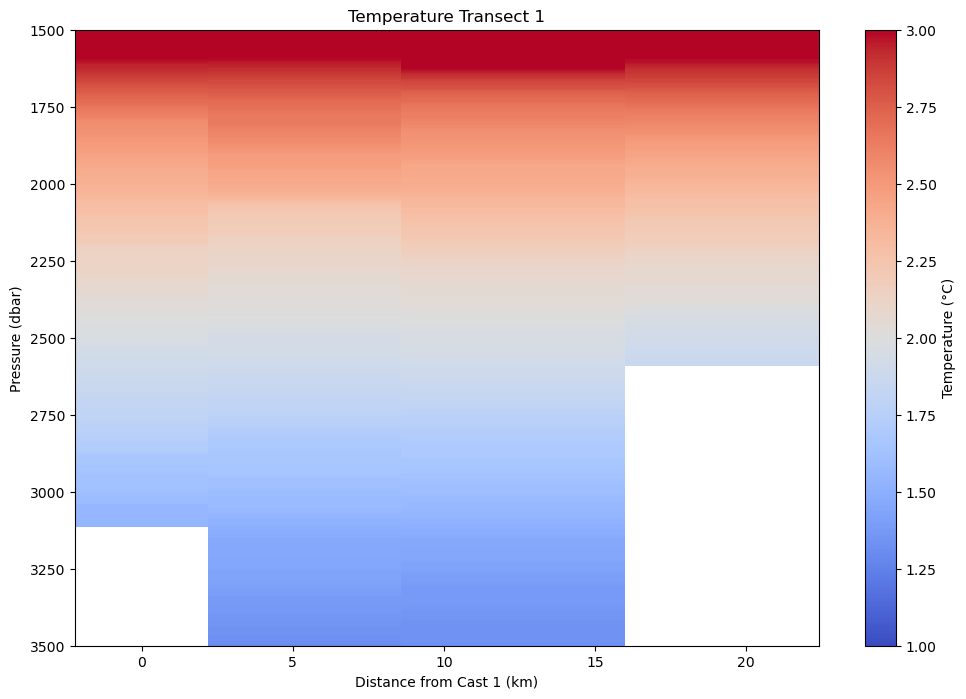

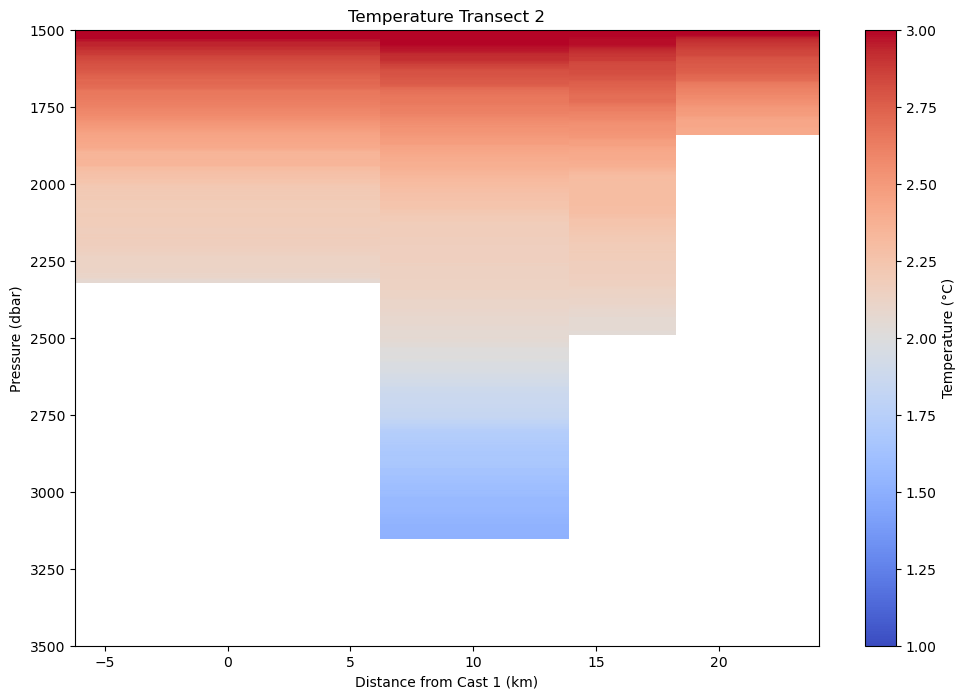

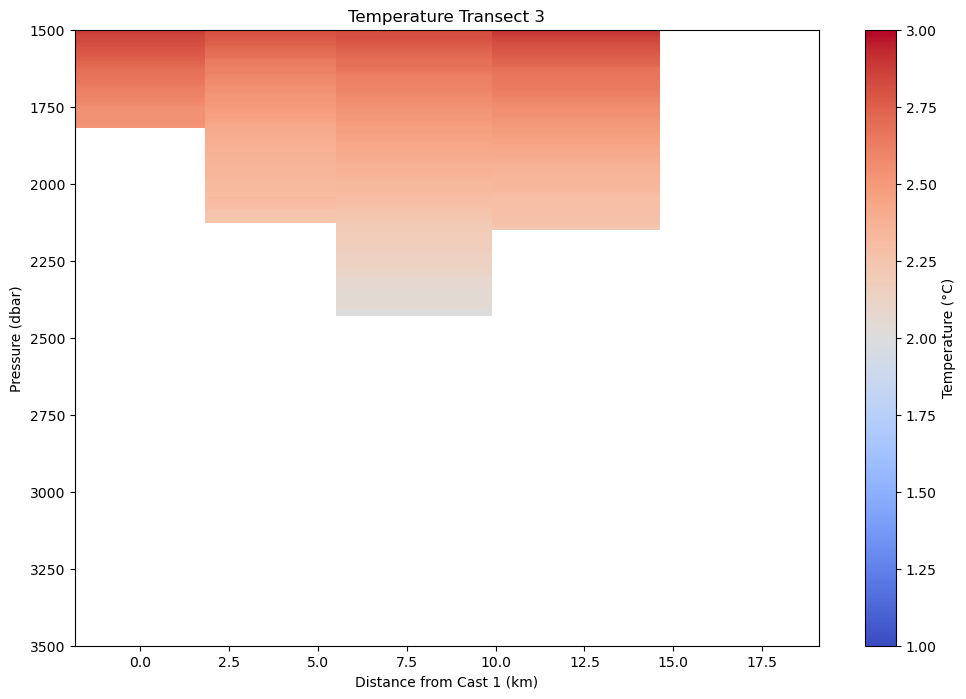

In [12]:
def plot_transect_deep(ds, transect_number):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Extract the data for plotting
    distance = ds['distance'].values
    pressure = ds['pressure'].values
    temperature = ds['temperature'].values
    
    # Create the meshgrid for distance and pressure
    X, Y = np.meshgrid(distance, pressure)
    
    
    # Plot the temperature as a color mesh
    c = ax.pcolormesh(X, Y, temperature.T, shading='auto', cmap='coolwarm',vmin=1,vmax=3)
    
    # Add color bar
    cb = fig.colorbar(c, ax=ax)
    cb.set_label('Temperature (°C)')
    
    # Set axis labels and title
    ax.set_xlabel('Distance from Cast 1 (km)')
    ax.set_ylabel('Pressure (dbar)')
    ax.set_title(f'Temperature Transect {transect_number}')
    
    # Reverse the y-axis to have pressure increasing downwards
        # Set color limits for temperature

    
    # Set y-axis limits for pressure
    ax.set_ylim(3500, 1500) 
    
    plt.show()

# Plot the transects
for i, ds in enumerate(transects_datasets):
    plot_transect_deep(ds, i + 1)

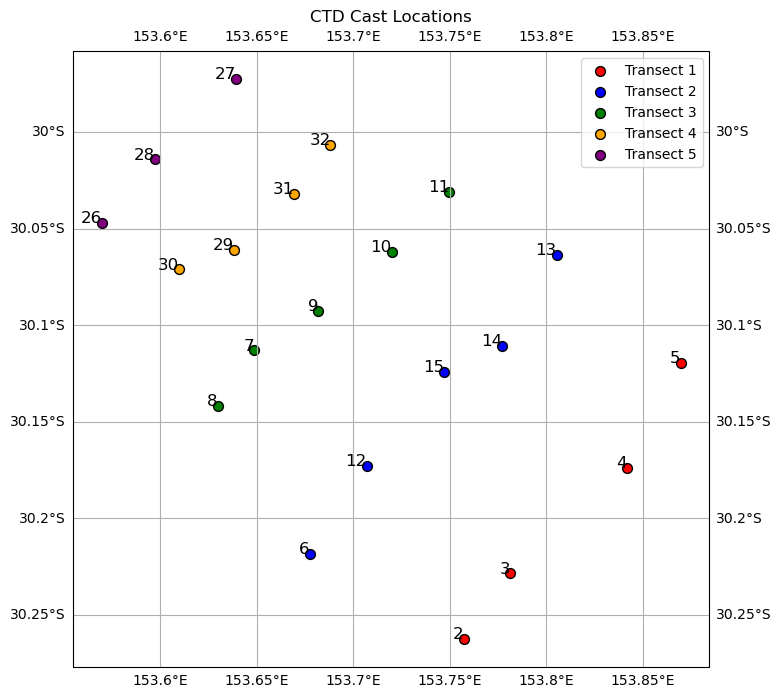

In [197]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add gridlines
ax.gridlines(draw_labels=True)

# Plot the CTD locations for each transect
colors = ['red', 'blue', 'green','orange','purple']

for i, casts in enumerate(transects_casts):
    latitudes = [cast['latitude'] for cast in casts]
    longitudes = [cast['longitude'] for cast in casts]
    ax.scatter(longitudes, latitudes, color=colors[i], edgecolor='black', s=50, label=f'Transect {i+1}')
    for j, (lat, lon) in enumerate(zip(latitudes, longitudes)):
        ax.text(lon, lat, str(transects_indices[i][j]+1), fontsize=12, ha='right')

# Set the title
ax.set_title('CTD Cast Locations')

# Add a legend
plt.legend()

# Show the plot
plt.show()

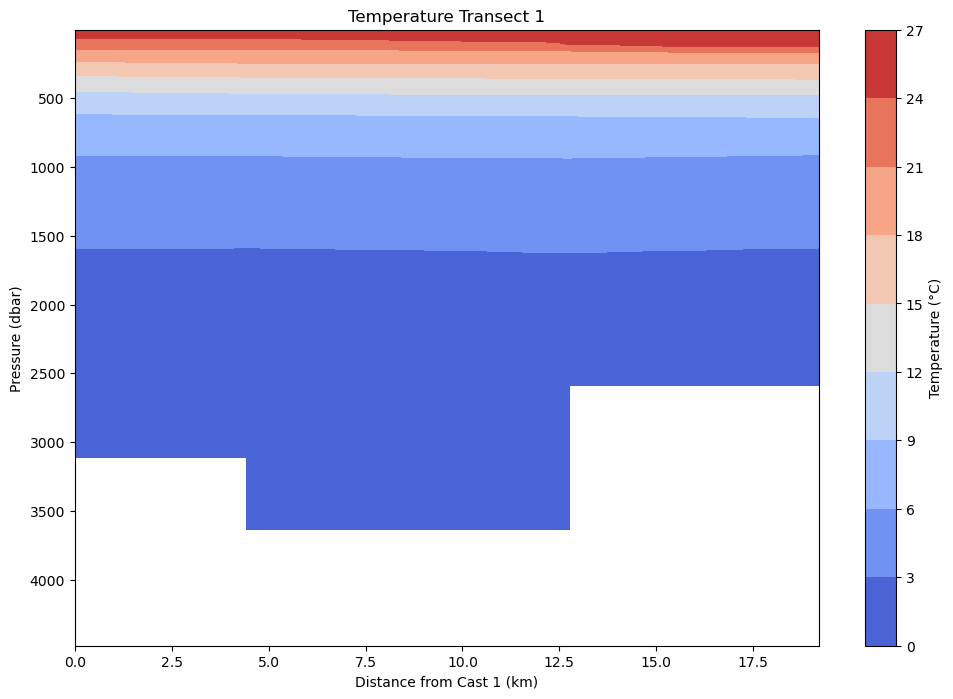

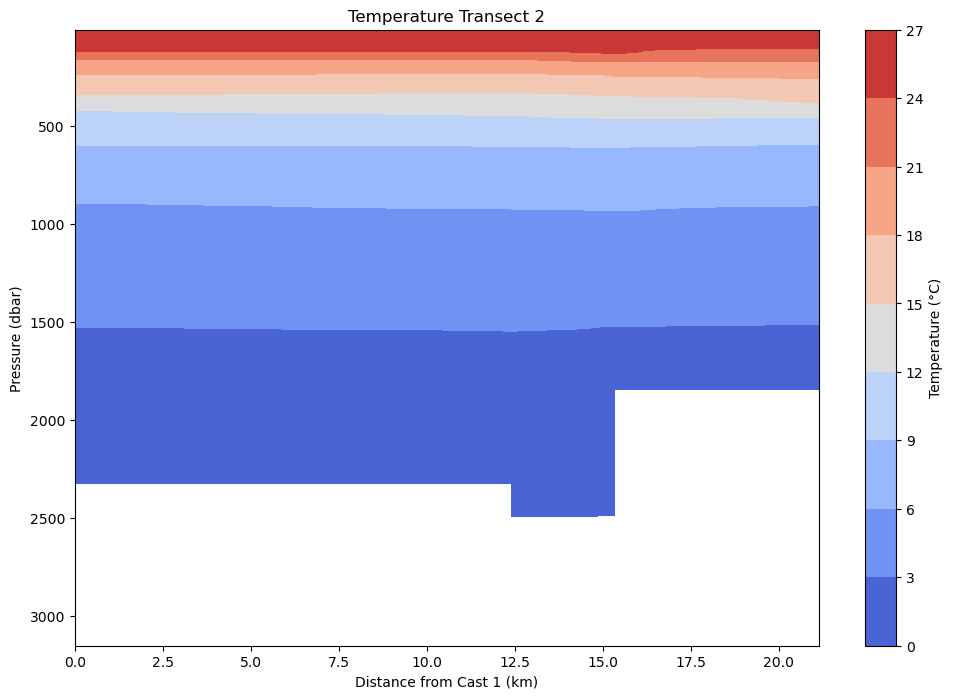

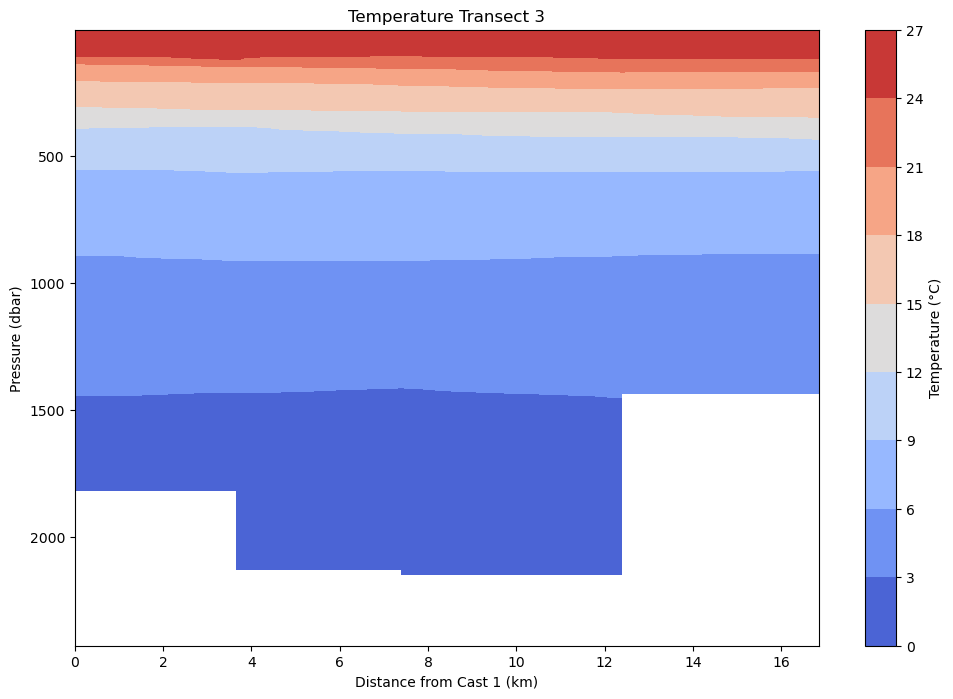

In [138]:
def plot_transect_con(ds, transect_number):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Extract the data for plotting
    distance = ds['distance'].values
    pressure = ds['pressure'].values
    temperature = ds['temperature'].values
    
    # Create the meshgrid for distance and pressure
    X, Y = np.meshgrid(distance, pressure)
    
    # Plot the temperature as filled contours
    c = ax.contourf(X, Y, temperature.T, cmap='coolwarm')
    
    # Add color bar
    cb = fig.colorbar(c, ax=ax)
    cb.set_label('Temperature (°C)')
    
    # Set axis labels and title
    ax.set_xlabel('Distance from Cast 1 (km)')
    ax.set_ylabel('Pressure (dbar)')
    ax.set_title(f'Temperature Transect {transect_number}')
    
    # Reverse the y-axis to have pressure increasing downwards
    ax.invert_yaxis()
    
    plt.show()

for i, ds in enumerate(transects_datasets):
    plot_transect_con(ds, i + 1)

Bottom Temperature Maps

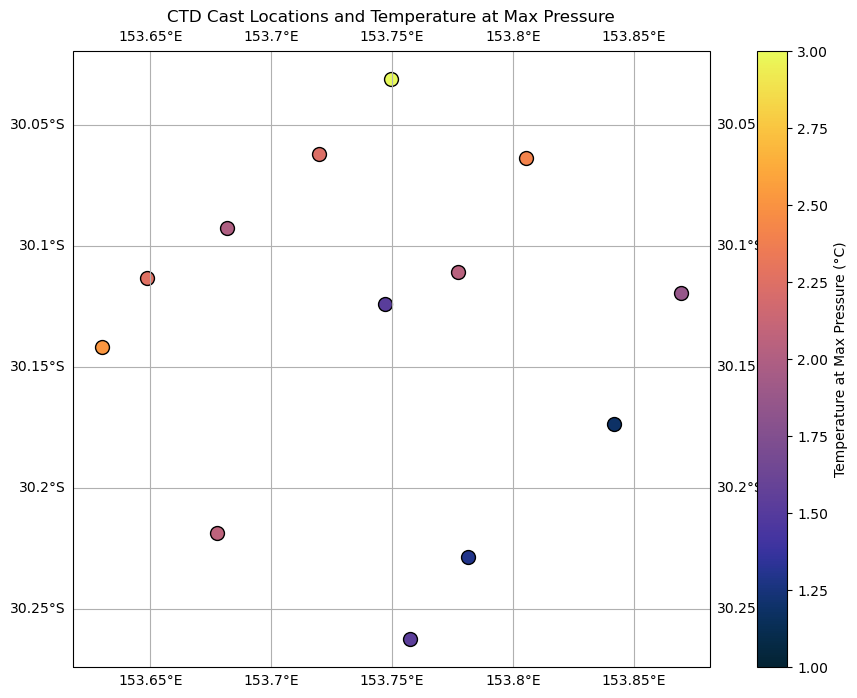

In [21]:
import cmocean

# Define the indices for each transect
transect1_indices = [1, 2, 3,4]
transect2_indices = [5, 14, 13, 12]
transect3_indices = [7,6, 8, 9, 10]

transects_indices = [transect1_indices, transect2_indices, transect3_indices]

# Process each transect
transects_casts = [process_casts(nc_files, indices) for indices in transects_indices]
transects_distances = [calculate_distances(casts) for casts in transects_casts]

# Create the combined datasets for each transect
transects_datasets = [create_dataset(casts, distances) for casts, distances in zip(transects_casts, transects_distances)]


def plot_ctd_locations_with_temperature(transect_casts):
    # Create the plot
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())


    # Add gridlines
    ax.gridlines(draw_labels=True)

    # Define colormap and normalize based on temperature range
    cmap = cmocean.cm.thermal
    norm = plt.Normalize(1, 3)  # Assuming temperature range 2-10 °C

    # Plot the CTD locations for each transect
    for i, casts in enumerate(transect_casts):
        for j, cast in enumerate(casts):
            lat = cast['latitude']
            lon = cast['longitude']
            cast_number = transects_indices[i][j]
            max_pressure_index = np.argmax(cast['pressure'])
            temperature_at_max_pressure = cast['temperature'][max_pressure_index]

            # Plot the point with color based on temperature
            sc = ax.scatter(lon, lat, color=cmap(norm(temperature_at_max_pressure)), edgecolor='black', s=100)

    # Add a color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for matplotlib < 3.1
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Temperature at Max Pressure (°C)')

    # Set the title
    ax.set_title('CTD Cast Locations and Temperature at Max Pressure')

    # Show the plot
    plt.show()

# Plot the CTD locations with temperature at max pressure
plot_ctd_locations_with_temperature(transects_casts)

In [185]:
def read_cast(file_path):
    # Function to read a single .nc file and extract relevant data
    ds = xr.open_dataset(file_path)
    cast = {
        'latitude': ds['latitude'].values.item(),
        'longitude': ds['longitude'].values.item(),
        'pressure': ds['pressure'].values,
        'temperature': ds['temperature'].values,
        'salinity': ds['salinity'].values,
    }
    ds.close()
    return cast

def process_all_casts(nc_files):
    # Function to process all .nc files in the directory
    casts = []
    for file_path in nc_files:
        cast = read_cast(file_path)
        casts.append(cast)
    return casts

def interpolate_casts(casts, common_pressures):
    interpolated_temperatures = []
    interpolated_salinities = []
    latitudes = []
    longitudes = []

    for cast in casts:
        latitudes.append(cast['latitude'])
        longitudes.append(cast['longitude'])

        # Ensure the pressure, temperature, and salinity are 1-dimensional
        pressure = np.ravel(cast['pressure'])
        temperature = np.ravel(cast['temperature'])
        salinity = np.ravel(cast['salinity'])

        # Check if pressure array is non-empty and contains numeric values
        if pressure.size > 0 and np.issubdtype(pressure.dtype, np.number):
            # Interpolate temperature and salinity to the common pressure grid
            interp_temp = np.interp(common_pressures, pressure, temperature, left=np.nan, right=np.nan)
            interp_salin = np.interp(common_pressures, pressure, salinity, left=np.nan, right=np.nan)
        else:
            interp_temp = np.full_like(common_pressures, np.nan)
            interp_salin = np.full_like(common_pressures, np.nan)

        interpolated_temperatures.append(interp_temp)
        interpolated_salinities.append(interp_salin)

    # Convert lists to numpy arrays
    interpolated_temperatures = np.array(interpolated_temperatures)
    interpolated_salinities = np.array(interpolated_salinities)
    latitudes = np.array(latitudes)
    longitudes = np.array(longitudes)

    return interpolated_temperatures, interpolated_salinities, latitudes, longitudes

def combine_casts_into_dataset(casts):
    # Define a common pressure grid
    min_pressure = min(cast['pressure'].min() for cast in casts)
    max_pressure = max(cast['pressure'].max() for cast in casts)
    common_pressures = np.linspace(min_pressure, max_pressure, num=100)

    # Interpolate all casts to the common pressure grid
    temperatures, salinities, latitudes, longitudes = interpolate_casts(casts, common_pressures)

    # Create a new xarray dataset
    dataset = xr.Dataset(
        {
            'temperature': (['cast', 'pressure'], temperatures),
            'salinity': (['cast', 'pressure'], salinities),
        },
        coords={
            'latitude': (['cast'], latitudes),
            'longitude': (['cast'], longitudes),
            'pressure': (['pressure'], common_pressures),
            'cast': (['cast'], np.arange(len(casts))),
        }
    )

    return dataset

# Directory containing the .nc files
nc_files_dir = 'Y:/in2024_v04/ctd/processing/in2024_v04/cap/cappro/avg'

# List all .nc files in the directory
nc_files = [os.path.join(nc_files_dir, file) for file in os.listdir(nc_files_dir) if file.endswith('.nc')]

# Process all casts
all_casts = process_all_casts(nc_files)

# Drop the first cast
all_casts = all_casts[1:]

# Combine all casts into a single xarray dataset
combined_dataset = combine_casts_into_dataset(all_casts)

# Display the combined dataset
print(combined_dataset)

<xarray.Dataset>
Dimensions:      (cast: 39, pressure: 100)
Coordinates:
    latitude     (cast) float64 -30.26 -30.23 -30.17 ... -28.26 -28.34 -28.26
    longitude    (cast) float64 153.8 153.8 153.8 153.9 ... 153.9 154.0 153.9
  * pressure     (pressure) float64 1.251 46.5 91.75 ... 4.436e+03 4.481e+03
  * cast         (cast) int32 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38
Data variables:
    temperature  (cast, pressure) float64 nan 24.07 23.66 21.33 ... nan nan nan
    salinity     (cast, pressure) float64 nan 35.49 35.55 35.65 ... nan nan nan


In [54]:
combined_dataset

<xarray.Dataset>
Dimensions:      (cast: 22, pressure: 100)
Coordinates:
    latitude     (cast) float64 -30.26 -30.23 -30.17 ... -30.07 -30.07 -30.07
    longitude    (cast) float64 153.8 153.8 153.8 153.9 ... 153.7 153.7 153.7
  * pressure     (pressure) float64 1.251 46.5 91.75 ... 4.436e+03 4.481e+03
  * cast         (cast) int32 0 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20 21
Data variables:
    temperature  (cast, pressure) float64 nan 24.07 23.66 21.33 ... nan nan nan
    salinity     (cast, pressure) float64 nan 35.49 35.55 35.65 ... nan nan nan

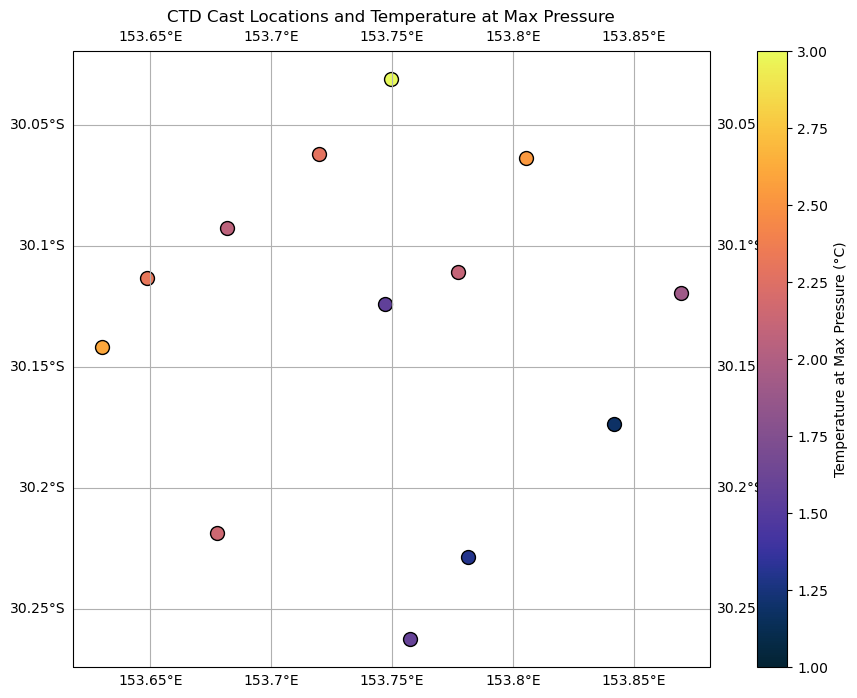

In [69]:
def plot_ctd_locations_with_temperature(transect_casts,level):
    # Create the plot
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())


    # Add gridlines
    ax.gridlines(draw_labels=True)

    # Define colormap and normalize based on temperature range
    cmap = cmocean.cm.thermal
    norm = plt.Normalize(1, 3)  # Assuming temperature range 2-10 °C

    # Plot the CTD locations for each transect
    for i, casts in enumerate(transect_casts):
        for j, cast in enumerate(casts):
            lat = cast['latitude']
            lon = cast['longitude']
            cast_number = transects_indices[i][j]
            max_pressure_index = np.argmax(cast['pressure'])-level
            temperature_at_max_pressure = cast['temperature'][max_pressure_index]

            # Plot the point with color based on temperature
            sc = ax.scatter(lon, lat, color=cmap(norm(temperature_at_max_pressure)), edgecolor='black', s=100)

    # Add a color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for matplotlib < 3.1
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Temperature at Max Pressure (°C)')

    # Set the title
    ax.set_title('CTD Cast Locations and Temperature at Max Pressure')

    # Show the plot
    plt.show()

# Plot the CTD locations with temperature at max pressure
plot_ctd_locations_with_temperature(transects_casts,100)

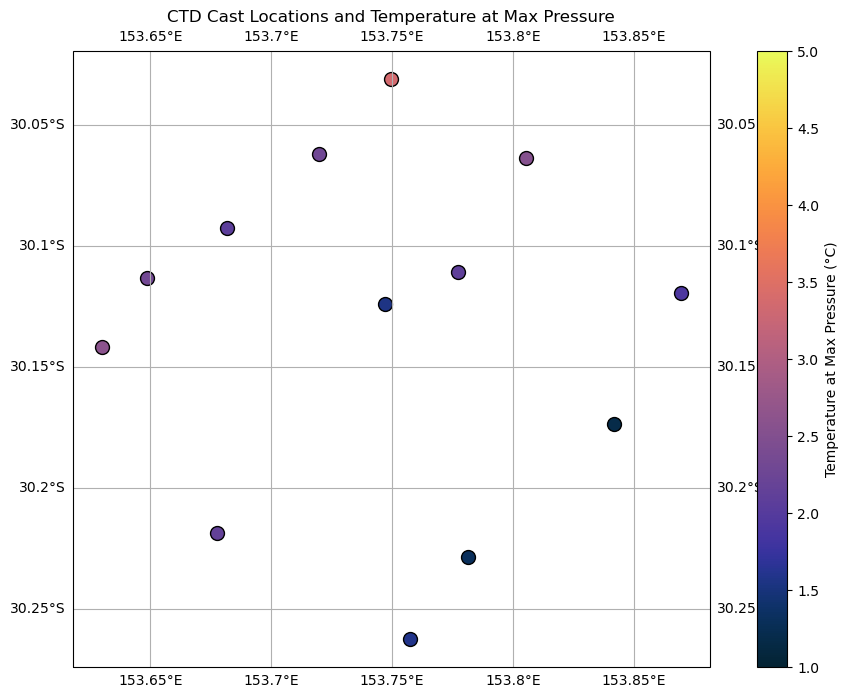

In [80]:
def plot_ctd_locations_with_temperature(transect_casts,level,temp_min,temp_max):
    # Create the plot
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())


    # Add gridlines
    ax.gridlines(draw_labels=True)

    # Define colormap and normalize based on temperature range
    cmap = cmocean.cm.thermal
    norm = plt.Normalize(temp_min, temp_max)  # Assuming temperature range 2-10 °C

    # Plot the CTD locations for each transect
    for i, casts in enumerate(transect_casts):
        for j, cast in enumerate(casts):
            lat = cast['latitude']
            lon = cast['longitude']
            cast_number = transects_indices[i][j]
            max_pressure_index = np.argmax(cast['pressure'])-level
            temperature_at_max_pressure = cast['temperature'][max_pressure_index]

            # Plot the point with color based on temperature
            sc = ax.scatter(lon, lat, color=cmap(norm(temperature_at_max_pressure)), edgecolor='black', s=100)

    # Add a color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for matplotlib < 3.1
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Temperature at Max Pressure (°C)')

    # Set the title
    ax.set_title('CTD Cast Locations and Temperature at Max Pressure')

    # Show the plot
    plt.show()

# Plot the CTD locations with temperature at max pressure
temp_min=1
temp_max=5
plot_ctd_locations_with_temperature(transects_casts,100,temp_min,temp_max)

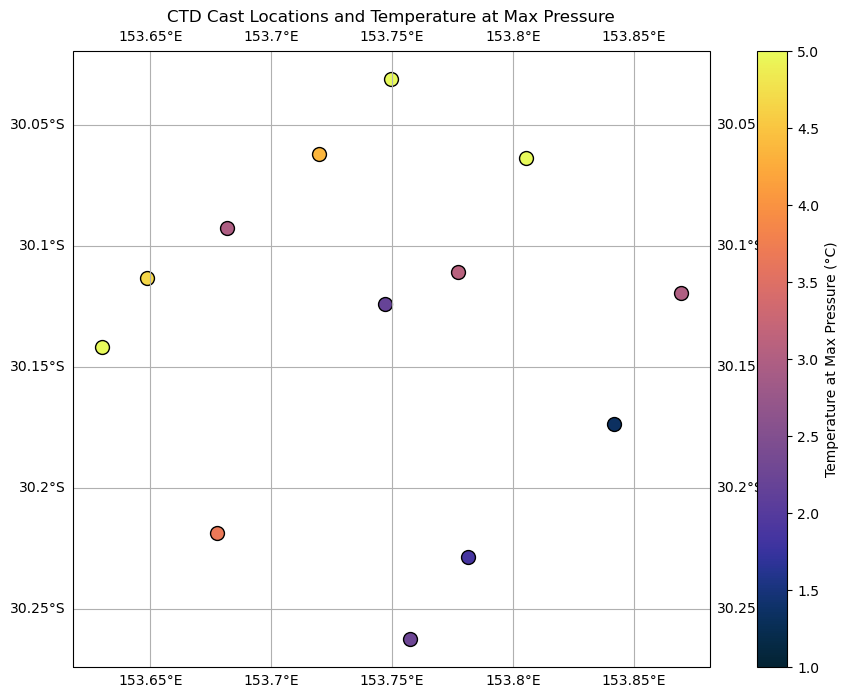

In [77]:
temp_min=1
temp_max=5
plot_ctd_locations_with_temperature(transects_casts,1000,temp_min,temp_max)

In [ ]:
multi=xr.open_dataset('Z:/Solitary_Island_Canyon_High_Res_Bathy.nc')
multi

In [205]:
def plot_ctd_locations_with_temperature(transect_casts, level, temp_min, temp_max):
    # Create the plot
    fig = plt.figure(figsize=(18, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([153.5, 154, -30.3, -29.9])
    im = ax.pcolormesh(multi.lon,multi.lat,multi.Band1,cmap='cmo.gray',zorder=1)
    ax.contour(multi.lon,multi.lat,multi.Band1,levels=np.arange(-4000,-100,500),colors='k',linewidths=.75,linestyles='solid',zorder=2)
    im.set_clim(-5000,0)

    # Add gridlines
    gl=ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = True
    gl.bottom_labels = True

    # Define colormap and normalize based on temperature range
    cmap = cmocean.cm.thermal
    norm = plt.Normalize(temp_min, temp_max)  # Assuming temperature range 1-5 °C

    # Plot the CTD locations for each transect
    for casts in transect_casts:
        for cast in casts:
            lat = cast['latitude']
            lon = cast['longitude']
            pressure = cast['pressure']
            temperature = cast['temperature']

            # Calculate maximum pressure and temperature at that pressure
            max_pressure_index = np.argmax(pressure)
            max_pressure = pressure[max_pressure_index]
            temperature_at_max_pressure = temperature[max_pressure_index]

            # Calculate pressure at the specified level
            specified_pressure_index = max_pressure_index - level
            if specified_pressure_index < 0:
                specified_pressure_index = 0  # Make sure index is non-negative
            specified_pressure = pressure[specified_pressure_index]

            temperature_at_specified_pressure = temperature[specified_pressure_index]

            # Plot the point with color based on temperature
            sc = ax.scatter(lon, lat, color=cmap(norm(temperature_at_specified_pressure)), edgecolor='black', s=150)

            # Annotate the point with pressure at the specified level
            ax.annotate(f'{specified_pressure:.1f} dbar', (lon, lat), xytext=(5, 5), textcoords='offset points', color='black')

    # Add a color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Temperature at Max Pressure (°C)')


    # Show the plot
    plt.show()


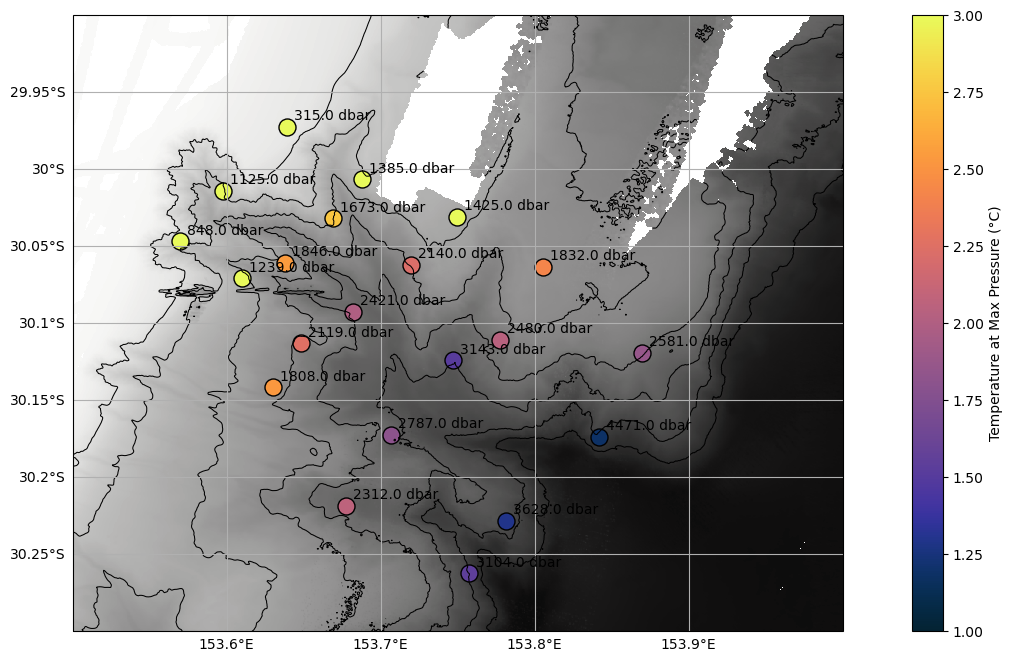

In [206]:
temp_min = 1
temp_max = 3
level = 10  # Example level, adjust as needed
plot_ctd_locations_with_temperature(transects_casts, level, temp_min, temp_max)


In [129]:
transects_indices = np.arange(1,len(nc_files))

# Process each transect
transects_casts_all = [process_casts(nc_files, transects_indices)]


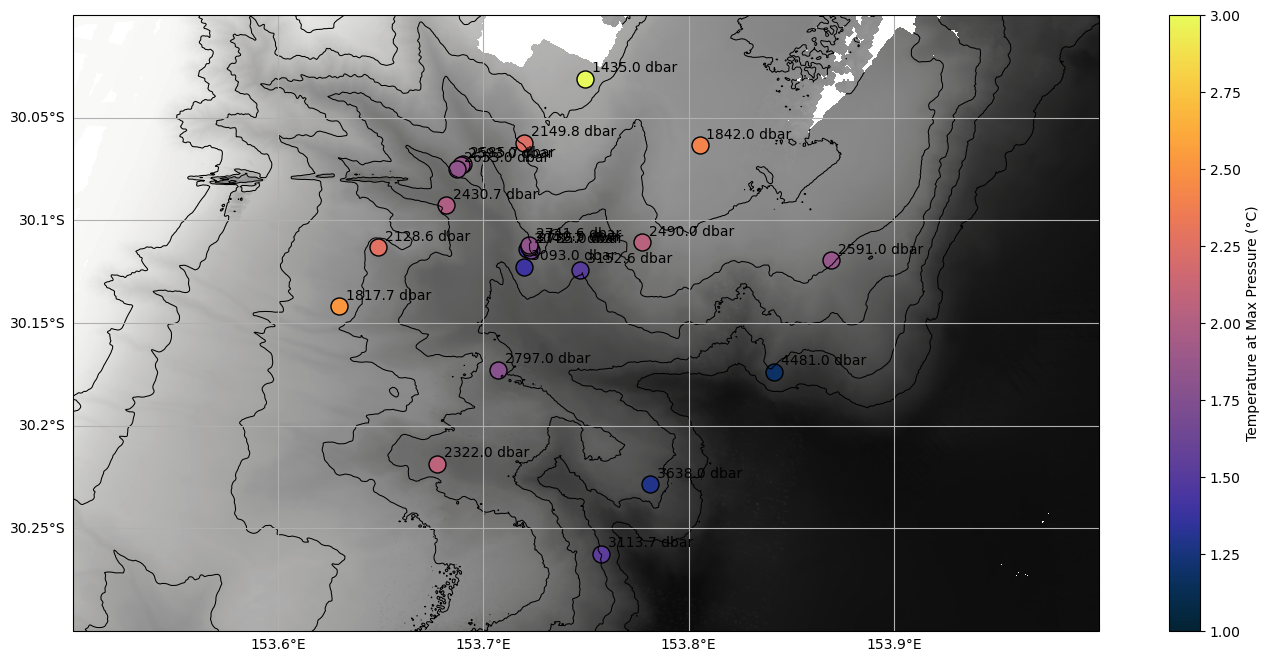

In [178]:
temp_min = 1
temp_max = 3
level = 0  # Example level, adjust as needed
plot_ctd_locations_with_temperature(transects_casts_all, level, temp_min, temp_max)

Calculate and plot density

In [199]:
def calculate_density(casts):
    densities = []
    for cast in casts:
        lat = cast['latitude']
        lon = cast['longitude']
        temperature = cast['temperature']
        salinity = cast['salinity']
        pressure = cast['pressure']
        SA = gsw.conversions.SA_from_SP(salinity, pressure, lon, lat)
        CT = gsw.conversions.CT_from_t(SA, temperature, pressure)
        density = gsw.density.sigma0(SA, CT)
        densities.append(density)
    return densities

def calculate_distances(casts):
    base_coord = (casts[0]['latitude'], casts[0]['longitude'])
    distances = [0]  # Distance from the first included cast is 0
    for cast in casts[1:]:
        coord = (cast['latitude'], cast['longitude'])
        distance = geodesic(base_coord, coord).kilometers
        distances.append(distance)
    return distances

def create_dataset_den(casts, densities,distances):
    # Determine the common pressure grid
    all_pressures = np.concatenate([cast['pressure'] for cast in casts])
    unique_pressures = np.unique(all_pressures)

    temp_interp = np.empty((len(casts), len(unique_pressures)))
    sal_interp = np.empty((len(casts), len(unique_pressures)))
    density_interp = np.empty((len(casts), len(unique_pressures)))

    for i, cast in enumerate(casts):
        temp_interp[i] = np.interp(unique_pressures, cast['pressure'], cast['temperature'])
        sal_interp[i] = np.interp(unique_pressures, cast['pressure'], cast['salinity'])
        density_interp[i] = np.interp(unique_pressures, cast['pressure'], densities[i])

    latitudes = np.array([cast['latitude'] for cast in casts])
    longitudes = np.array([cast['longitude'] for cast in casts])
    times = np.array([cast['time'] for cast in casts])

    # Fill values below the seafloor (maximum pressure) with NaN
    for i, cast in enumerate(casts):
        max_pressure = np.max(cast['pressure'])
        temp_interp[i][unique_pressures > max_pressure] = np.nan
        sal_interp[i][unique_pressures > max_pressure] = np.nan
        density_interp[i][unique_pressures > max_pressure] = np.nan

    ds = xr.Dataset(
        {
            'temperature': (['cast', 'pressure'], temp_interp),
            'salinity': (['cast', 'pressure'], sal_interp),
            'latitude': (['cast'], latitudes),
            'longitude': (['cast'], longitudes),
            'time': (['cast'], times),
            'density': (['cast', 'pressure'], density_interp),
            'distance': (['cast'], distances)
        },
        coords={
            'cast': np.arange(len(casts)),
            'pressure': unique_pressures,
        }
    )
    return ds

# Assuming process_casts and transects_indices are defined elsewhere
transects_casts = [process_casts(nc_files, indices) for indices in transects_indices]
transects_dens = [calculate_density(casts) for casts in transects_casts]
transects_distances = [calculate_distances(casts) for casts in transects_casts]

# Create the combined datasets for each transect
transects_datasets = [create_dataset_den(casts, dens, distances) for casts, dens, distances in zip(transects_casts, transects_dens, transects_distances)]

transects_datasets



[<xarray.Dataset>
 Dimensions:      (cast: 4, pressure: 4483)
 Coordinates:
   * cast         (cast) int32 0 1 2 3
   * pressure     (pressure) float64 1.251 2.0 3.0 ... 4.48e+03 4.481e+03
 Data variables:
     temperature  (cast, pressure) float64 24.07 24.07 24.07 ... nan nan nan
     salinity     (cast, pressure) float64 35.49 35.49 35.49 ... nan nan nan
     latitude     (cast) float64 -30.26 -30.23 -30.17 -30.12
     longitude    (cast) float64 153.8 153.8 153.8 153.9
     time         (cast) datetime64[ns] 2024-06-09T18:43:28.296001536 ... 2024...
     density      (cast, pressure) float64 24.0 24.0 24.0 24.0 ... nan nan nan
     distance     (cast) float64 0.0 4.422 12.77 19.19,
 <xarray.Dataset>
 Dimensions:      (cast: 5, pressure: 3149)
 Coordinates:
   * cast         (cast) int32 0 1 2 3 4
   * pressure     (pressure) float64 7.0 7.229 7.232 ... 3.152e+03 3.153e+03
 Data variables:
     temperature  (cast, pressure) float64 24.32 24.32 24.32 ... nan nan nan
     salinity    

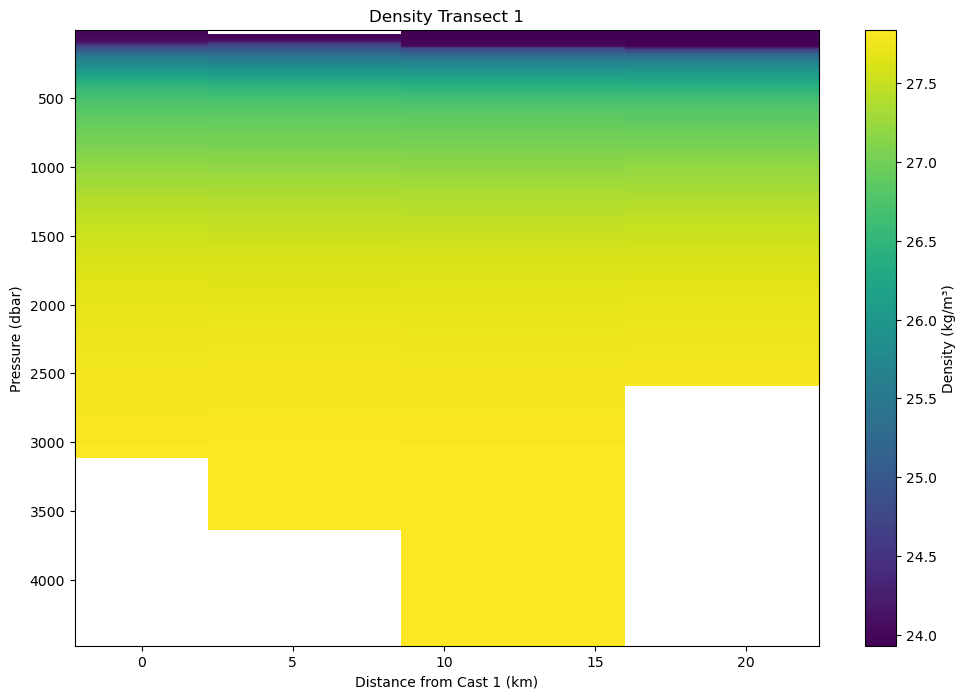

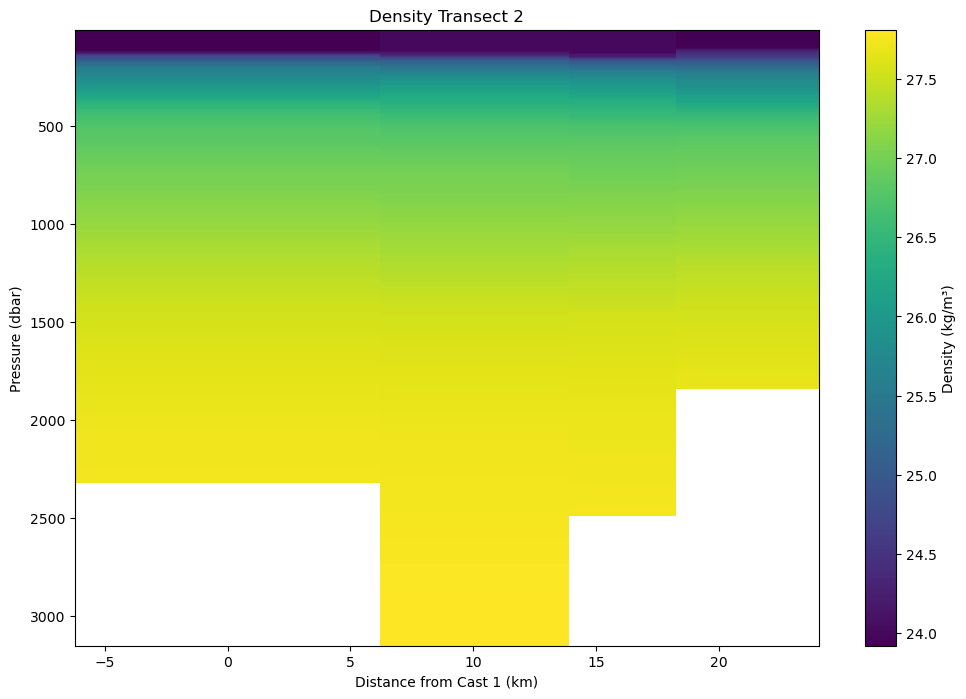

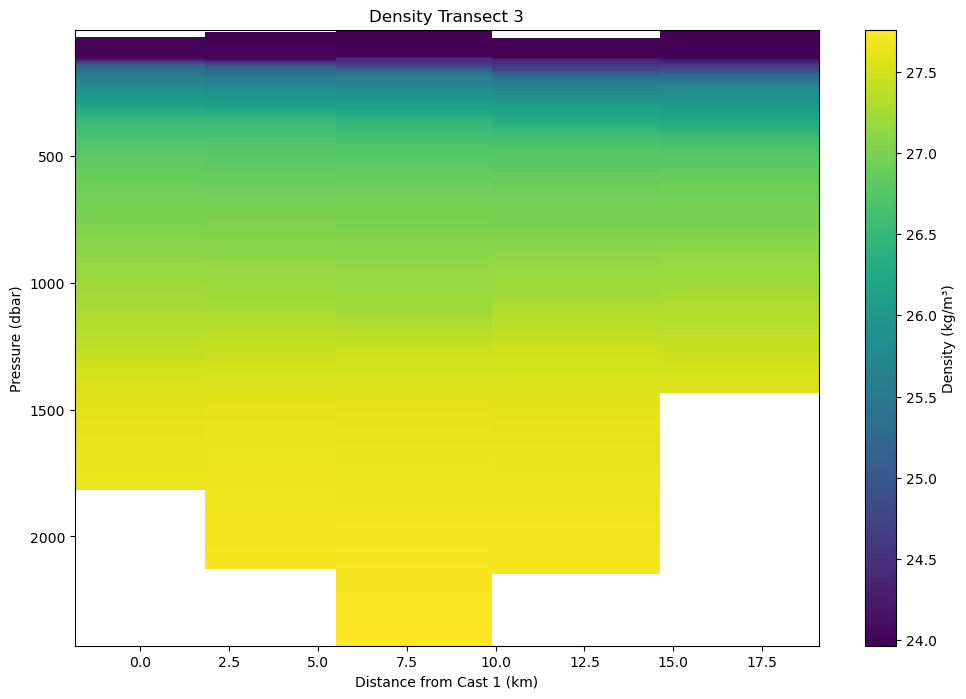

In [165]:
def plot_transect(ds, transect_number):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Extract the data for plotting
    distance = ds['distance'].values
    pressure = ds['pressure'].values
    density = ds['density'].values
    
    # Create the meshgrid for distance and pressure
    X, Y = np.meshgrid(distance, pressure)
    
    # Plot the density as a color mesh
    c = ax.pcolormesh(X, Y, density.T, shading='auto', cmap='viridis')
    
    # Add color bar
    cb = fig.colorbar(c, ax=ax)
    cb.set_label('Density (kg/m³)')
    
    # Set axis labels and title
    ax.set_xlabel('Distance from Cast 1 (km)')
    ax.set_ylabel('Pressure (dbar)')
    ax.set_title(f'Density Transect {transect_number}')
    
    # Reverse the y-axis to have pressure increasing downwards
    ax.invert_yaxis()
    
    plt.show()

# Plot the transects
for i, ds in enumerate(transects_datasets):
    plot_transect(ds, i + 1)

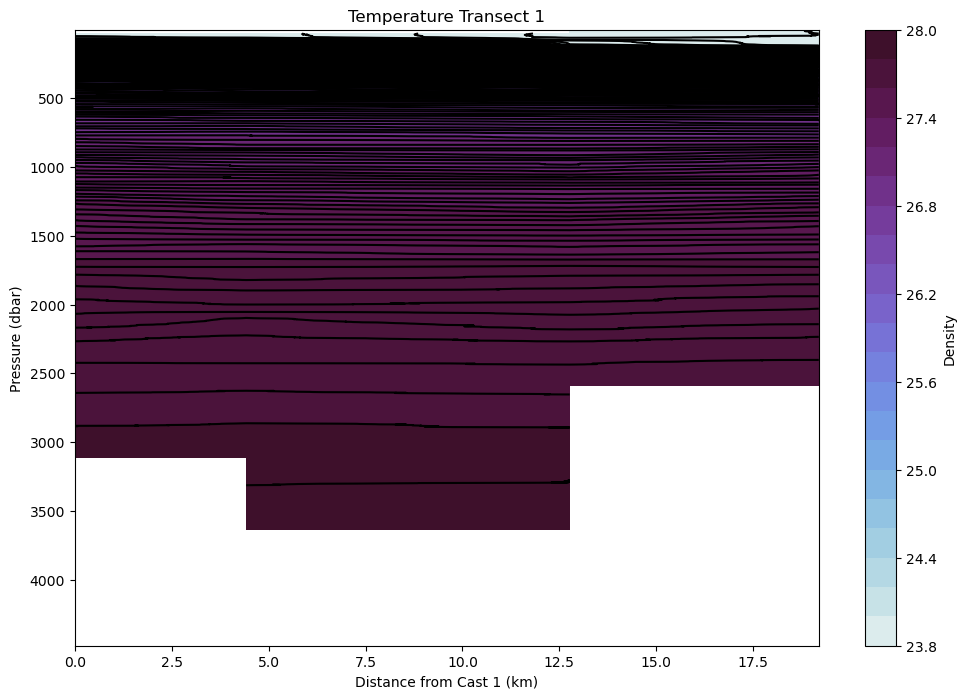

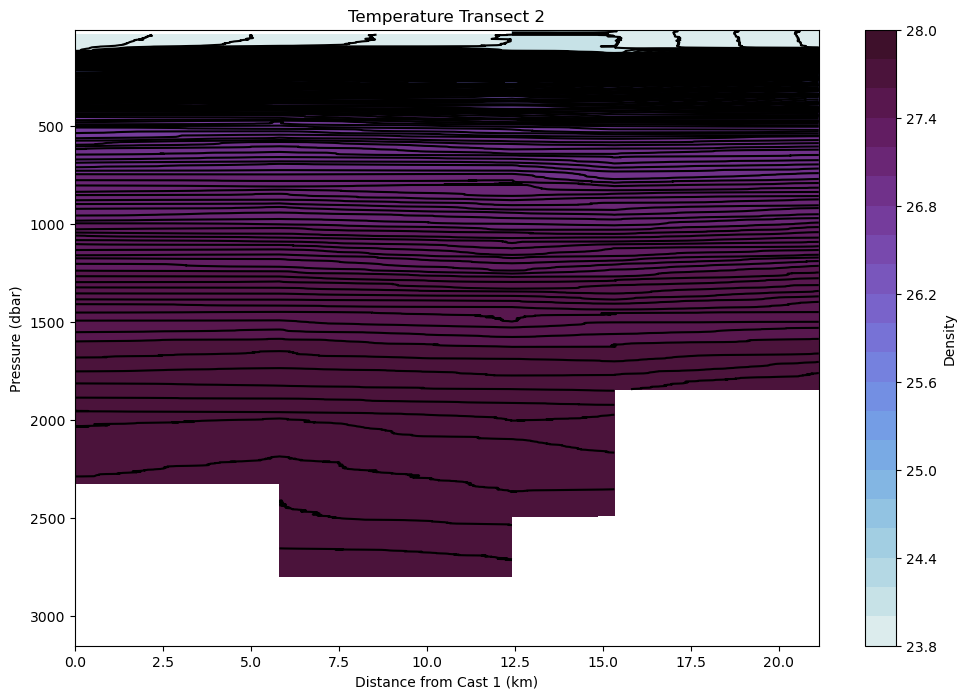

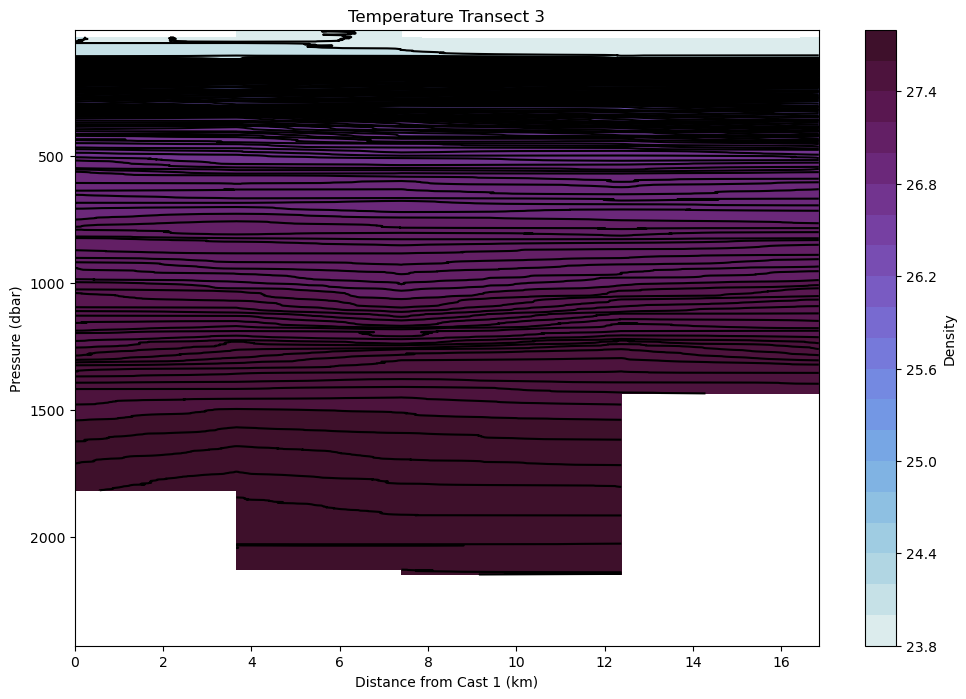

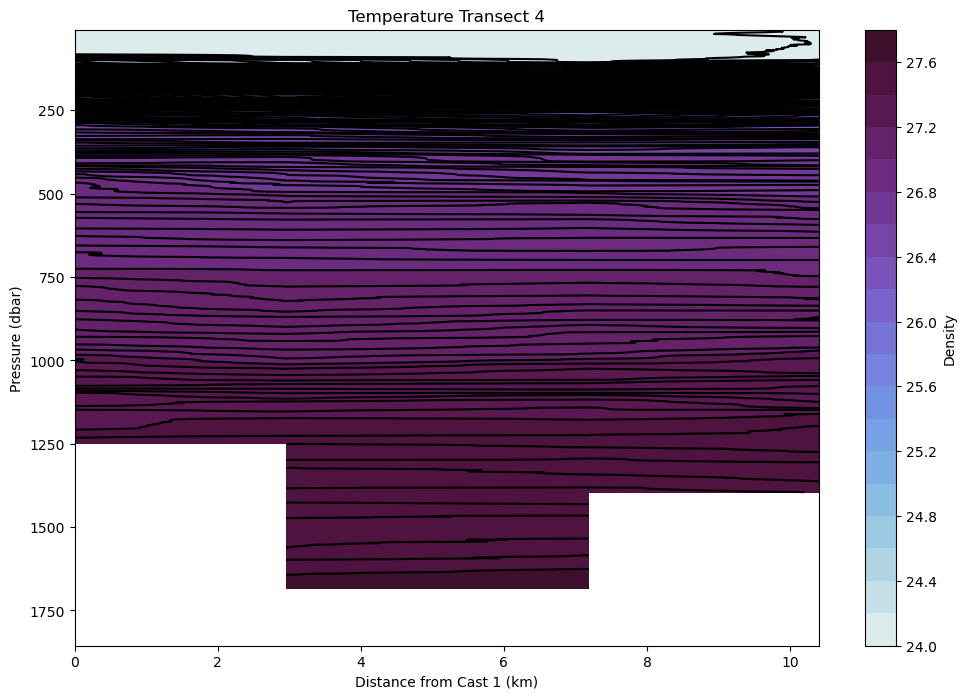

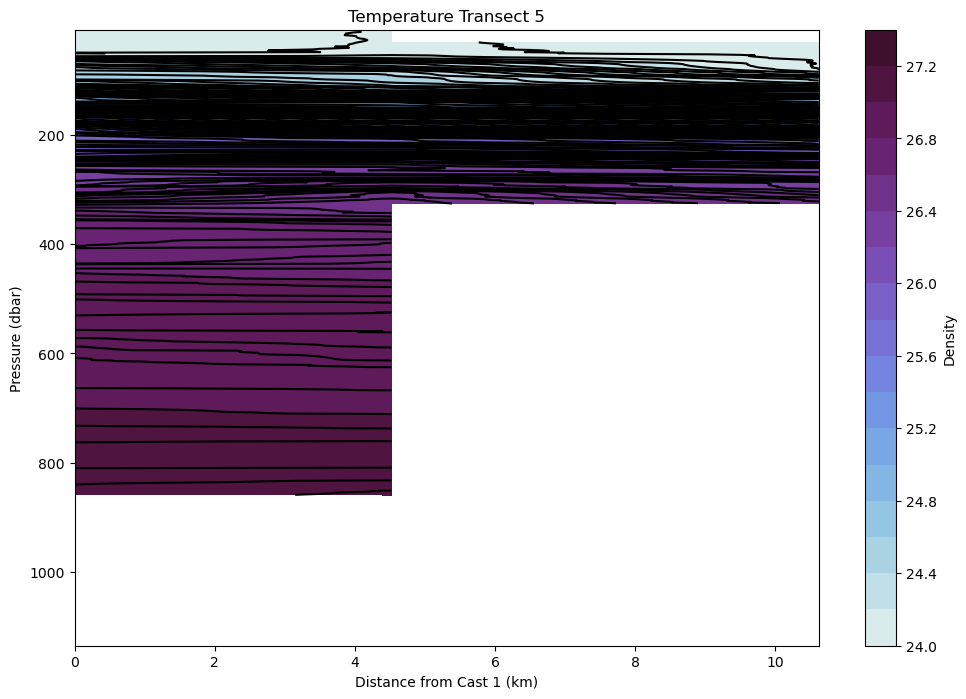

In [200]:
def plot_transect_con(ds, transect_number):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Extract the data for plotting
    distance = ds['distance'].values
    pressure = ds['pressure'].values
    density= ds['density'].values
    
    # Create the meshgrid for distance and pressure
    X, Y = np.meshgrid(distance, pressure)
    
    # Plot the temperature as filled contours
    c = ax.contourf(X, Y, density.T,levels=20, cmap='cmo.dense')
    ax.contour(X, Y, density.T,levels=200,colors='k')
    # Add color bar
    cb = fig.colorbar(c, ax=ax)
    cb.set_label('Density')
    
    # Set axis labels and title
    ax.set_xlabel('Distance from Cast 1 (km)')
    ax.set_ylabel('Pressure (dbar)')
    ax.set_title(f'Temperature Transect {transect_number}')
    
    # Reverse the y-axis to have pressure increasing downwards
    ax.invert_yaxis()
    
    plt.show()

for i, ds in enumerate(transects_datasets):
    plot_transect_con(ds, i + 1)

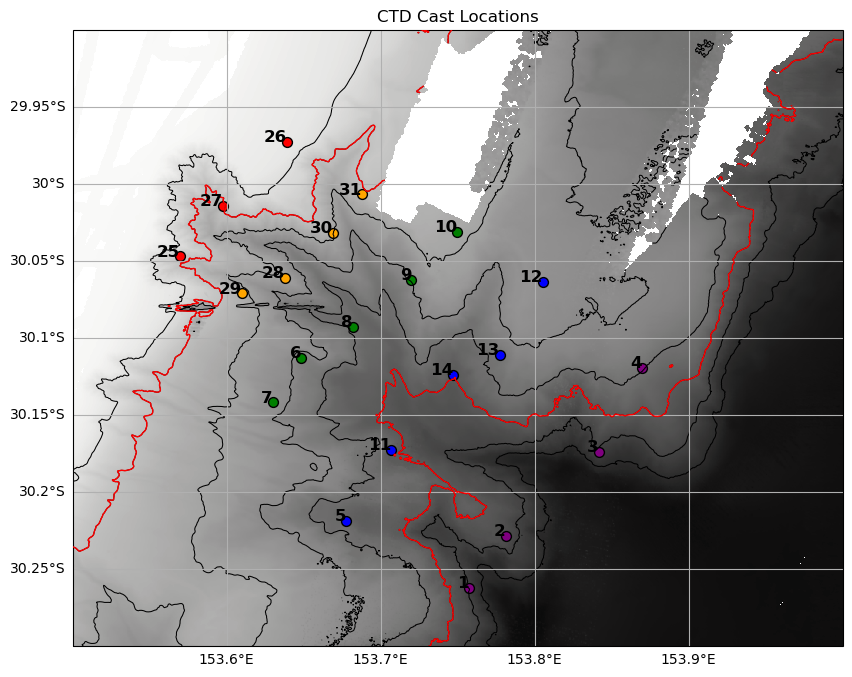

In [216]:
def ctd_casts_bathy(transect_casts):
    # Create the plot
    fig = plt.figure(figsize=(18, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([153.5, 154, -30.3, -29.9])
    im = ax.pcolormesh(multi.lon,multi.lat,multi.Band1,cmap='cmo.gray',zorder=1)
    ax.contour(multi.lon,multi.lat,multi.Band1,levels=np.arange(-4000,-100,500),colors='k',linewidths=.75,linestyles='solid',zorder=2)
    ax.contour(multi.lon,multi.lat,multi.Band1,levels=[-3000,-1000],colors='red',linewidths=1,linestyles='solid',zorder=3)
    im.set_clim(-5000,0)

    # Add gridlines
    gl=ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = True
    gl.bottom_labels = True

    # Plot the CTD locations for each transect
    colors = ['purple', 'blue', 'green','orange','red']

    for i, casts in enumerate(transects_casts):
        latitudes = [cast['latitude'] for cast in casts]
        longitudes = [cast['longitude'] for cast in casts]
        ax.scatter(longitudes, latitudes, color=colors[i], edgecolor='black', s=50, label=f'Transect {i+1}')
        for j, (lat, lon) in enumerate(zip(latitudes, longitudes)):
            ax.text(lon, lat, str(transects_indices[i][j]), fontsize=12,fontweight='bold', ha='right')

    # Set the title
    ax.set_title('CTD Cast Locations')

    # Show the plot
    plt.show()

ctd_casts_bathy(transect_casts)